### Import Libraries

In [1]:
%load_ext tensorboard
from numpy.random import seed
seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
print(tf.__version__)

2.3.0


### Import Data 

In [2]:
pd.options.display.float_format = '{:.1f}'.format
hcv_dataframe = pd.read_excel('hcv.xlsx','hcvdata')
hcv_dataframe = hcv_dataframe.reindex(np.random.permutation(hcv_dataframe.index))
hcv_dataframe.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
469,470,0=Blood Donor,52,f,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2
592,593,3=Cirrhosis,47,m,42.0,nan,159.0,102.0,11.0,6.3,5.5,58.0,201.0,79.0
265,266,0=Blood Donor,58,m,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1
84,85,0=Blood Donor,39,m,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2
109,110,0=Blood Donor,42,m,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0


### Pre-Processing 

In [3]:
hcv_dataframe = hcv_dataframe.dropna(axis=0) 
selected_features = hcv_dataframe.drop(columns = ['Unnamed: 0','Category'])
selected_features.head()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
469,52,f,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2
265,58,m,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1
84,39,m,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2
109,42,m,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0
412,46,f,39.9,73.9,14.0,17.2,16.3,6.9,5.1,71.0,12.7,64.7


In [4]:
selected_features.shape

(589, 12)

In [5]:
selected_features['Sex'] = hcv_dataframe['Sex'].astype('category').cat.codes
selected_features.head(5)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
469,52,0,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2
265,58,1,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1
84,39,1,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2
109,42,1,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0
412,46,0,39.9,73.9,14.0,17.2,16.3,6.9,5.1,71.0,12.7,64.7


In [6]:
output_targets = hcv_dataframe['Category'].astype('category').cat.codes
output_targets.head()

469    0
265    0
84     0
109    0
412    0
dtype: int8

### Train/Validation Split 

In [7]:
#examples for validation data
training_examples = selected_features.tail(489)
training_targets = output_targets.tail(489)

# Normalize the training data
scaler = StandardScaler().fit(training_examples.values)
scaledf = scaler.transform(training_examples.values)
training_examples = pd.DataFrame(scaledf, index=training_examples.index, columns=training_examples.columns)


#  examples for validation.
validation_examples = selected_features.head(100)
validation_targets = output_targets.head(100)

# Normalize the validation data
scaler = StandardScaler().fit(validation_examples.values)
scaledf = scaler.transform(validation_examples.values)
validation_examples = pd.DataFrame(scaledf, index=validation_examples.index, columns=validation_examples.columns)

training_examples.head(10)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
338,-1.3,-1.3,-0.9,0.1,-0.6,-0.4,-0.5,0.8,0.2,-0.3,-0.2,0.5
606,0.2,-1.3,-1.5,5.6,-1.2,0.1,-0.3,-0.6,-1.3,7.3,1.5,-2.4
389,-0.3,-1.3,0.7,-0.5,-0.3,-0.4,-0.5,1.0,1.2,-0.1,-0.3,0.5
60,-1.0,0.8,1.6,0.8,-0.4,-0.3,-0.0,0.2,1.1,0.2,-0.3,0.8
178,0.1,0.8,0.5,-0.5,-0.3,-0.3,0.5,-1.2,0.3,-0.1,-0.2,0.6
158,-0.1,0.8,-0.7,1.1,0.3,0.0,-0.6,0.7,1.2,-0.1,0.5,-0.3
356,-1.0,-1.3,-0.4,-0.4,-0.7,-0.4,-0.4,-1.0,0.4,-0.2,-0.5,-0.2
297,1.7,0.8,-0.1,0.6,0.0,-0.3,-0.1,-0.3,0.5,-0.1,-0.3,-0.6
452,0.4,-1.3,0.8,0.1,2.2,1.0,-0.3,-0.2,-0.5,-0.2,0.3,1.2
295,1.6,0.8,-1.1,0.2,0.0,-0.1,0.8,-0.1,1.0,0.2,-0.0,-0.6


### Check Baseline

In [8]:
print("check the distribution of training target:")
frequency = training_targets.value_counts(normalize =True)
print(frequency * 100)

print("check the distribution of validation target:")
frequency = validation_targets.value_counts(normalize =True)
print(frequency * 100)


check the distribution of training target:
0   89.0
4    3.7
2    3.5
3    2.5
1    1.4
dtype: float64
check the distribution of validation target:
0   91.0
4    6.0
2    3.0
dtype: float64


### Build Model 

In [44]:
baseline_model = keras.Sequential([
    keras.layers.Dense(12, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation=tf.nn.relu),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])


baseline_model.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 45        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [45]:
from keras.callbacks import EarlyStopping
EPOCHS = 60
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',patience=3)
b_history = baseline_model.fit(training_examples, training_targets, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_targets), verbose=1,
                    callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 [==============================] - 0s 10ms/step - loss: 1.7298 - sparse_categorical_accuracy: 0.1636 - val_loss: 1.6735 - val_sparse_categorical_accuracy: 0.1500
Epoch 2/60
16/16 [==============================] - 0s 2ms/step - loss: 1.5763 - sparse_categorical_accuracy: 0.3661 - val_loss: 1.5227 - val_sparse_categorical_accuracy: 0.4200
Epoch 3/60
16/16 [==============================] - 0s 2ms/step - loss: 1.4341 - sparse_categorical_accuracy: 0.6012 - val_loss: 1.3794 - val_sparse_categorical_accuracy: 0.6800
Epoch 4/60
16/16 [==============================] - 0s 3ms/step - loss: 1.2967 - sparse_categorical_accuracy: 0.7485 - val_loss: 1.2370 - val_sparse_categorical_accuracy: 0.8200
Epoch 5/60
16/16 [==============================] - 0s 3ms/step - loss: 1.1598 - sparse_categorical_accuracy: 0.8282 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.8600
Epoch 6/60
16/16 [==============================] - 0s 4ms/step - loss: 1.0352 - sparse_categorical_accuracy:

Epoch 47/60
16/16 [==============================] - 0s 4ms/step - loss: 0.2070 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.9600
Epoch 48/60
16/16 [==============================] - 0s 6ms/step - loss: 0.2034 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1377 - val_sparse_categorical_accuracy: 0.9600
Epoch 49/60
16/16 [==============================] - 0s 5ms/step - loss: 0.1998 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9600
Epoch 50/60
16/16 [==============================] - 0s 4ms/step - loss: 0.1965 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1315 - val_sparse_categorical_accuracy: 0.9600
Epoch 51/60
16/16 [==============================] - 0s 4ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.1308 - val_sparse_categorical_accuracy: 0.9600
Epoch 52/60
16/16 [==============================] - 0s 6ms/step - loss: 0.1904 - sparse_categorical_accu

### Check minimum and maximum validation accuracy

In [46]:
print("Minimum accuracy of validation: ", min(b_history.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_history.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.15000000596046448
Maximum accuracy of validation:  0.9599999785423279


### Check minimum and maximum accuracy

In [47]:
print("Minimum accuracy of Model: ", min(b_history.history['sparse_categorical_accuracy']))
print("Maximum accuracy of Model: ", max(b_history.history['sparse_categorical_accuracy']))

Minimum accuracy of Model:  0.1635991781949997
Maximum accuracy of Model:  0.9406952857971191


In [48]:
validation_examples.iloc[1:10]

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
265,1.2,0.8,-0.0,-0.3,-0.8,-0.4,-0.3,-0.1,-0.0,-1.3,-0.4,-0.5
84,-1.0,0.8,0.5,0.5,4.3,1.4,-0.2,0.7,-1.0,1.4,0.8,-1.4
109,-0.6,0.8,0.5,-0.6,-0.1,-0.5,-0.2,1.0,0.5,1.1,-0.3,0.1
412,-0.2,-1.3,-0.3,0.1,-0.8,-0.6,0.1,-0.6,-0.6,-0.5,-0.4,-1.7
486,0.7,-1.3,0.4,0.2,-0.3,-0.4,-0.2,-0.2,1.0,-0.8,-0.3,0.2
212,0.4,0.8,1.9,-0.4,0.6,0.1,-0.3,1.3,0.2,1.0,-0.2,1.8
414,-0.2,-1.3,-0.1,-0.6,-0.3,-0.6,-0.2,-0.4,-1.2,-1.2,-0.4,-0.6
436,0.1,-1.3,0.6,-0.1,-0.5,-0.5,0.1,-1.5,-1.5,-0.8,-0.4,-0.3
393,-0.4,-1.3,-1.2,-0.1,-0.3,-0.6,-0.3,0.8,0.4,-1.3,-0.3,-0.7


In [14]:
valpreds = baseline_model.predict_on_batch(validation_examples.iloc[1:20])
print(valpreds)

[[9.96366739e-01 1.56789413e-03 7.49837433e-04 1.26948336e-03
  4.60425981e-05]
 [6.11310840e-01 1.00798555e-01 1.92752451e-01 8.90874639e-02
  6.05068449e-03]
 [9.91768003e-01 1.19849015e-03 4.69062477e-03 2.32006446e-03
  2.28398058e-05]
 [9.97229517e-01 1.47187756e-03 2.83636997e-04 9.77488118e-04
  3.74980227e-05]
 [9.97331142e-01 1.70331402e-03 2.18407295e-04 7.14819820e-04
  3.22820924e-05]
 [9.57564950e-01 2.17578560e-03 3.11416592e-02 9.08502284e-03
  3.25251131e-05]
 [9.95431423e-01 1.38526107e-03 1.16319291e-03 1.99363008e-03
  2.64321534e-05]
 [9.73336458e-01 5.37557667e-03 7.46515673e-03 1.33982785e-02
  4.24455240e-04]
 [9.97581482e-01 1.70210609e-03 1.53110232e-04 5.37672313e-04
  2.57016945e-05]
 [9.95741904e-01 1.76507700e-03 1.20447832e-03 1.26016373e-03
  2.83579702e-05]
 [9.85735476e-01 2.27568951e-03 6.71192352e-03 5.23576559e-03
  4.11915353e-05]
 [9.98596013e-01 1.05527625e-03 6.61567319e-05 2.72004167e-04
  1.04379587e-05]
 [7.25419581e-01 8.82023387e-03 2.146091

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(validation_targets.iloc[1:20])

265    0
84     0
109    0
412    0
486    0
212    0
414    0
436    0
393    0
141    0
1      0
468    0
108    0
470    0
55     0
551    2
80     0
503    0
199    0
dtype: int8


In [50]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = baseline_model.predict_classes(validation_examples)
print(classification_report(validation_targets,predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        91
           2       0.00      0.00      0.00         3
           4       1.00      0.83      0.91         6

    accuracy                           0.96       100
   macro avg       0.66      0.61      0.63       100
weighted avg       0.94      0.96      0.95       100



In [51]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = baseline_model.predict_classes(training_examples)
print(classification_report(training_targets,predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       435
           1       0.00      0.00      0.00         7
           2       0.57      0.24      0.33        17
           3       0.50      0.67      0.57        12
           4       0.78      0.78      0.78        18

    accuracy                           0.94       489
   macro avg       0.56      0.54      0.53       489
weighted avg       0.92      0.94      0.93       489



#### Plot Results

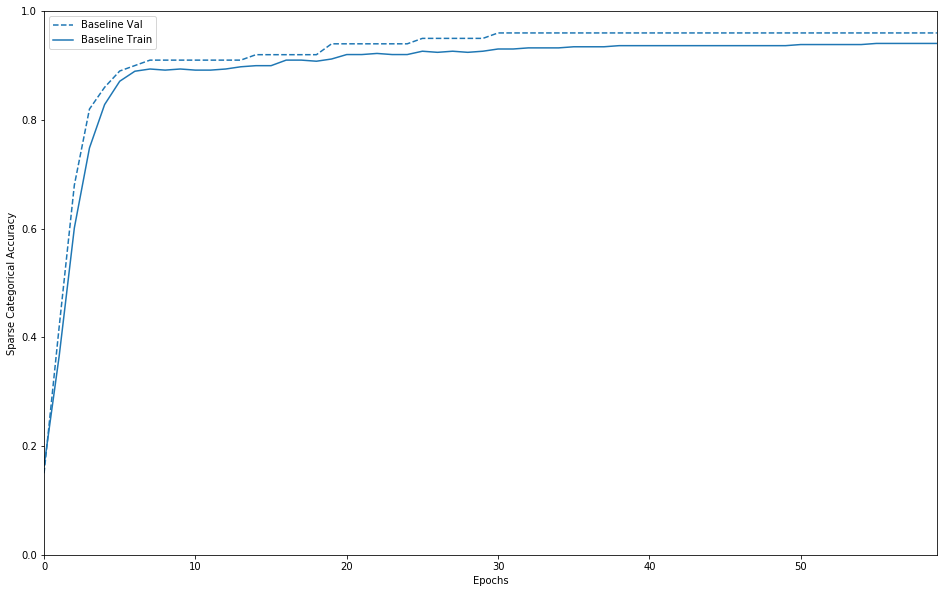

In [52]:
import matplotlib.pyplot as plt


def plot_history(histories, key='sparse_categorical_accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('baseline', b_history)])

### Inference :

The output of this model is discrete, multiclass classification, so the activation function used here is 'softmax', loss function as 'sparse_categorical_crossentropy' , optimizer as 'adam' and metric as 'accuracy'. The baseline for this model is calculated using majority classification rule. The majority class here is 'Blood Donor' (coded as 0 class). The baseline accuracy is 89.0%. The model is able to exceed baseline performance with maximum accuracy of 97%.

### Build Model with 2 hidden layers

In [53]:
baseline_model2 = keras.Sequential([
    keras.layers.Dense(12, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(8, activation=tf.nn.relu),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])


baseline_model2.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 45        
Total params: 377
Trainable params: 377
Non-trainable params: 0
_________________________________________________________________


In [20]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 60
b_history2 = baseline_model2.fit(training_examples,training_targets,epochs=EPOCHS,
                   validation_data= (validation_examples, validation_targets),verbose=2,
                               callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 - 0s - loss: 1.7064 - sparse_categorical_accuracy: 0.1063 - val_loss: 1.6780 - val_sparse_categorical_accuracy: 0.1200
Epoch 2/60
16/16 - 0s - loss: 1.6225 - sparse_categorical_accuracy: 0.2618 - val_loss: 1.6021 - val_sparse_categorical_accuracy: 0.3100
Epoch 3/60
16/16 - 0s - loss: 1.5669 - sparse_categorical_accuracy: 0.5153 - val_loss: 1.5478 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/60
16/16 - 0s - loss: 1.5238 - sparse_categorical_accuracy: 0.7505 - val_loss: 1.5023 - val_sparse_categorical_accuracy: 0.8100
Epoch 5/60
16/16 - 0s - loss: 1.4852 - sparse_categorical_accuracy: 0.8528 - val_loss: 1.4583 - val_sparse_categorical_accuracy: 0.8900
Epoch 6/60
16/16 - 0s - loss: 1.4467 - sparse_categorical_accuracy: 0.8957 - val_loss: 1.4121 - val_sparse_categorical_accuracy: 0.9300
Epoch 7/60
16/16 - 0s - loss: 1.4049 - sparse_categorical_accuracy: 0.9018 - val_loss: 1.3634 - val_sparse_categorical_accuracy: 0.9500
Epoch 8/60
16/16 - 0s - loss: 1.3567 - sparse_ca

In [54]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = baseline_model2.predict_classes(validation_examples)
print(classification_report(validation_targets,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.00      0.00      0.00         0
           2       0.02      0.67      0.04         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         6

    accuracy                           0.02       100
   macro avg       0.00      0.13      0.01       100
weighted avg       0.00      0.02      0.00       100



### Check minimum and maximum validation accuracy

In [55]:
print("Minimum accuracy of validation: ", min(b_history2.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_history2.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.11999999731779099
Maximum accuracy of validation:  0.9599999785423279


### Check minimum and maximum model accuracy

In [56]:
print("Minimum accuracy of model: ", min(b_history2.history['sparse_categorical_accuracy']))
print("Maximum accuracy of model: ", max(b_history2.history['sparse_categorical_accuracy']))

Minimum accuracy of model:  0.1063394695520401
Maximum accuracy of model:  0.9447852969169617


### 2.a Plot Results : To Compare model with 1 hidden layer vs 2 hidden layer

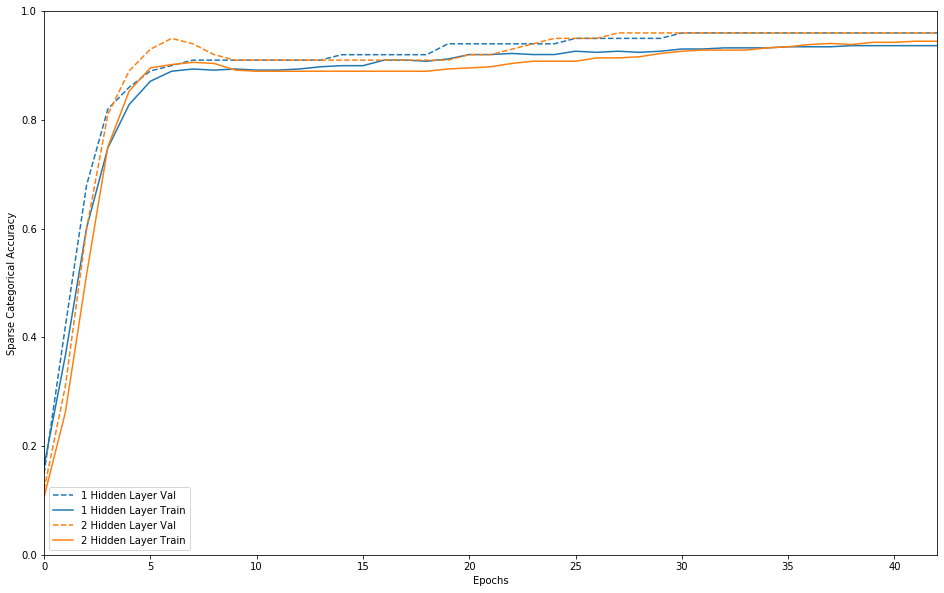

In [57]:
plot_history([('1 Hidden Layer', b_history), 
            ('2 Hidden Layer', b_history2) ])

## b.	No of neurons in hidden layers between 
### (a)2/3 the size of the input layer, plus the size of the output layer
### (b) twice the size of the input layer

In [58]:
#(a) Model with 2/3 the size of the input layer(12), plus the size of the output layer(5)

baseline_model3 = keras.Sequential([
    keras.layers.Dense(12, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(13, activation=tf.nn.relu),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])


baseline_model3.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model3.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_27 (Dense)             (None, 13)                169       
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 70        
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


In [59]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 60
b_history3= baseline_model3.fit(training_examples,training_targets,epochs=EPOCHS,
                   validation_data= (validation_examples, validation_targets),verbose=2,
                               callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 - 0s - loss: 1.7915 - sparse_categorical_accuracy: 0.0900 - val_loss: 1.6470 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/60
16/16 - 0s - loss: 1.5707 - sparse_categorical_accuracy: 0.4151 - val_loss: 1.4186 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/60
16/16 - 0s - loss: 1.3926 - sparse_categorical_accuracy: 0.6933 - val_loss: 1.2382 - val_sparse_categorical_accuracy: 0.8500
Epoch 4/60
16/16 - 0s - loss: 1.2420 - sparse_categorical_accuracy: 0.8303 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.9100
Epoch 5/60
16/16 - 0s - loss: 1.1004 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.9139 - val_sparse_categorical_accuracy: 0.9200
Epoch 6/60
16/16 - 0s - loss: 0.9727 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.7689 - val_sparse_categorical_accuracy: 0.9300
Epoch 7/60
16/16 - 0s - loss: 0.8506 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.9200
Epoch 8/60
16/16 - 0s - loss: 0.7437 - sparse_ca

### Check minimum and maximum validation accuracy

In [60]:
print("Minimum accuracy of validation: ", min(b_history3.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_history3.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.10000000149011612
Maximum accuracy of validation:  0.9700000286102295


### Check minimum and maximum model accuracy

In [61]:
print("Minimum accuracy of model: ", min(b_history3.history['sparse_categorical_accuracy']))
print("Maximum accuracy of model: ", max(b_history3.history['sparse_categorical_accuracy']))

Minimum accuracy of model:  0.08997955173254013
Maximum accuracy of model:  0.9550102353096008


In [62]:
#(b) Model with twice the size of the input layer


baseline_model4 = keras.Sequential([
    keras.layers.Dense(12, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(24, activation=tf.nn.relu),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])


baseline_model4.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_30 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 125       
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [63]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 60
b_history4= baseline_model4.fit(training_examples,training_targets,epochs=EPOCHS,
                   validation_data= (validation_examples, validation_targets),verbose=2,
                               callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 - 0s - loss: 1.4804 - sparse_categorical_accuracy: 0.5849 - val_loss: 1.2713 - val_sparse_categorical_accuracy: 0.7800
Epoch 2/60
16/16 - 0s - loss: 1.2355 - sparse_categorical_accuracy: 0.8364 - val_loss: 1.0405 - val_sparse_categorical_accuracy: 0.8800
Epoch 3/60
16/16 - 0s - loss: 1.0403 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.8537 - val_sparse_categorical_accuracy: 0.9100
Epoch 4/60
16/16 - 0s - loss: 0.8877 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.7055 - val_sparse_categorical_accuracy: 0.9100
Epoch 5/60
16/16 - 0s - loss: 0.7635 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.5897 - val_sparse_categorical_accuracy: 0.9100
Epoch 6/60
16/16 - 0s - loss: 0.6652 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.5020 - val_sparse_categorical_accuracy: 0.9100
Epoch 7/60
16/16 - 0s - loss: 0.5893 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.4292 - val_sparse_categorical_accuracy: 0.9100
Epoch 8/60
16/16 - 0s - loss: 0.5303 - sparse_ca

### Check minimum and maximum validation accuracy

In [64]:
print("Minimum accuracy of validation: ", min(b_history4.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_history4.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.7799999713897705
Maximum accuracy of validation:  0.9700000286102295


### Check minimum and maximum model accuracy

In [66]:
print("Minimum accuracy of model: ", min(b_history4.history['sparse_categorical_accuracy']))
print("Maximum accuracy of model: ", max(b_history4.history['sparse_categorical_accuracy']))

Minimum accuracy of model:  0.5848670601844788
Maximum accuracy of model:  0.9734151363372803


### Plot Results 

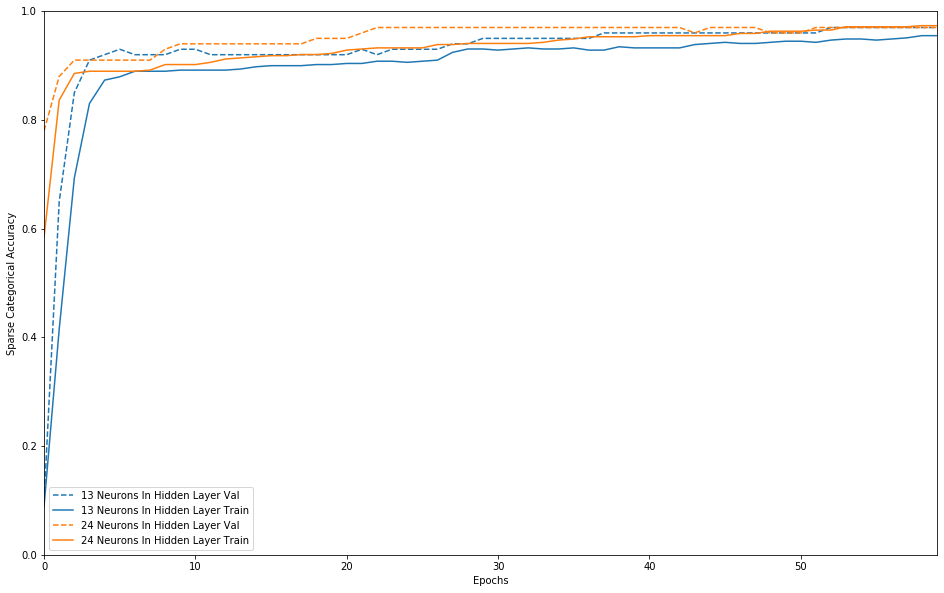

In [67]:
plot_history([('13 Neurons in hidden layer', b_history3), 
            ('24 Neurons in hidden layer', b_history4)])

## c.	Regularization 

In [68]:
baseline_model_l1 = keras.Sequential([
    keras.layers.Dense(12, kernel_regularizer=keras.regularizers.l1(0.01), activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(8,kernel_regularizer=keras.regularizers.l1(0.01), activation=tf.nn.relu),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])

baseline_model_l1.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model_l1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 45        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [69]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 60
b_historyl1= baseline_model_l1.fit(training_examples,training_targets,epochs=EPOCHS,
                   validation_data= (validation_examples, validation_targets),verbose=2,
                               callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 - 0s - loss: 2.1529 - sparse_categorical_accuracy: 0.2290 - val_loss: 2.0998 - val_sparse_categorical_accuracy: 0.3700
Epoch 2/60
16/16 - 0s - loss: 2.0095 - sparse_categorical_accuracy: 0.5235 - val_loss: 1.9468 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/60
16/16 - 0s - loss: 1.8787 - sparse_categorical_accuracy: 0.6953 - val_loss: 1.8028 - val_sparse_categorical_accuracy: 0.7200
Epoch 4/60
16/16 - 0s - loss: 1.7556 - sparse_categorical_accuracy: 0.7771 - val_loss: 1.6682 - val_sparse_categorical_accuracy: 0.8100
Epoch 5/60
16/16 - 0s - loss: 1.6417 - sparse_categorical_accuracy: 0.8098 - val_loss: 1.5365 - val_sparse_categorical_accuracy: 0.8500
Epoch 6/60
16/16 - 0s - loss: 1.5317 - sparse_categorical_accuracy: 0.8405 - val_loss: 1.4201 - val_sparse_categorical_accuracy: 0.8500
Epoch 7/60
16/16 - 0s - loss: 1.4349 - sparse_categorical_accuracy: 0.8548 - val_loss: 1.3173 - val_sparse_categorical_accuracy: 0.8600
Epoch 8/60
16/16 - 0s - loss: 1.3478 - sparse_ca

### Check minimum and maximum validation accuracy

In [70]:
print("Minimum accuracy of validation: ", min(b_historyl1.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_historyl1.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.3700000047683716
Maximum accuracy of validation:  0.9700000286102295


### Check minimum and maximum model accuracy

In [72]:
print("Minimum accuracy of model: ", min(b_historyl1.history['sparse_categorical_accuracy']))
print("Maximum accuracy of model: ", max(b_historyl1.history['sparse_categorical_accuracy']))

Minimum accuracy of model:  0.22903884947299957
Maximum accuracy of model:  0.9284253716468811


### Plot Result :

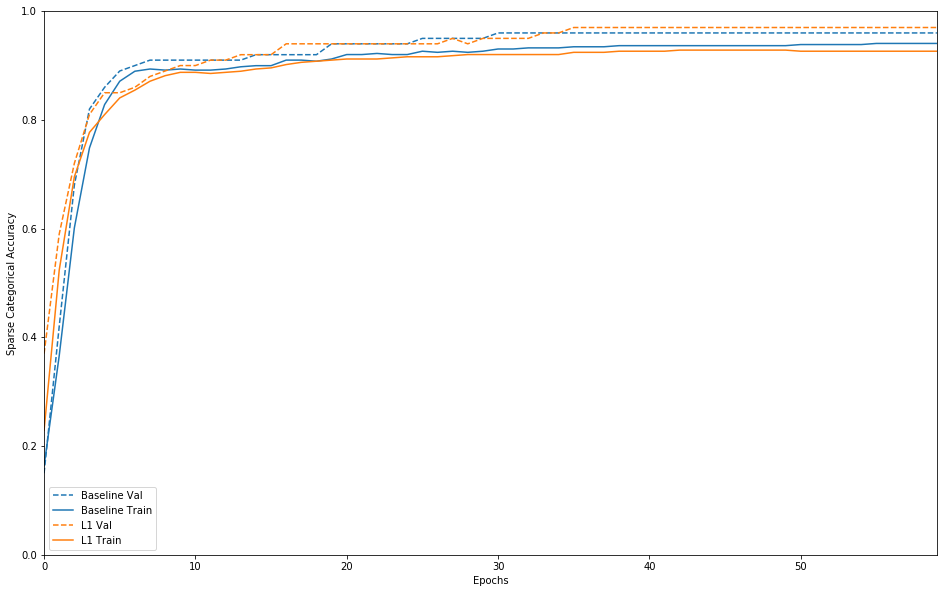

In [73]:
plot_history([('Baseline', b_history), 
            ('L1', b_historyl1)])

## d.	Activation function - ReLU and your choice

In [39]:
baseline_model_tanh = keras.Sequential([
    keras.layers.Dense(12, activation=tf.nn.tanh,
                       input_shape=(training_examples.shape[1],)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(7, activation=tf.nn.tanh),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation=tf.nn.softmax)

  ])


baseline_model_tanh.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['sparse_categorical_accuracy'])
baseline_model_tanh.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 91        
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 40        
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import EarlyStopping
EPOCHS = 60
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',patience=3)
b_history_tanh = baseline_model_tanh.fit(training_examples, training_targets, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_targets), verbose=1,
                    callbacks=[early_stopping_monitor])

Epoch 1/60
16/16 [==============================] - 0s 29ms/step - loss: 1.7240 - sparse_categorical_accuracy: 0.1513 - val_loss: 1.6880 - val_sparse_categorical_accuracy: 0.2700
Epoch 2/60
16/16 [==============================] - 0s 4ms/step - loss: 1.5820 - sparse_categorical_accuracy: 0.2802 - val_loss: 1.5575 - val_sparse_categorical_accuracy: 0.3900
Epoch 3/60
16/16 [==============================] - 0s 3ms/step - loss: 1.4505 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.4333 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/60
16/16 [==============================] - 0s 3ms/step - loss: 1.3236 - sparse_categorical_accuracy: 0.5583 - val_loss: 1.3109 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/60
16/16 [==============================] - 0s 4ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.7014 - val_loss: 1.1841 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/60
16/16 [==============================] - 0s 2ms/step - loss: 1.0705 - sparse_categorical_accuracy:

Epoch 47/60
16/16 [==============================] - 0s 3ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.1070 - val_sparse_categorical_accuracy: 0.9700
Epoch 48/60
16/16 [==============================] - 0s 3ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1059 - val_sparse_categorical_accuracy: 0.9700
Epoch 49/60
16/16 [==============================] - 0s 4ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1034 - val_sparse_categorical_accuracy: 0.9700
Epoch 50/60
16/16 [==============================] - 0s 4ms/step - loss: 0.1428 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.1017 - val_sparse_categorical_accuracy: 0.9700
Epoch 51/60
16/16 [==============================] - 0s 5ms/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.0999 - val_sparse_categorical_accuracy: 0.9700
Epoch 52/60
16/16 [==============================] - 0s 5ms/step - loss: 0.1392 - sparse_categorical_accu

### Check minimum and maximum validation accuracy

In [41]:
print("Minimum accuracy of validation: ", min(b_history_tanh.history['val_sparse_categorical_accuracy']))
print("Maximum accuracy of validation: ", max(b_history_tanh.history['val_sparse_categorical_accuracy']))

Minimum accuracy of validation:  0.27000001072883606
Maximum accuracy of validation:  0.9800000190734863


### Check minimum and maximum model accuracy


In [42]:
print("Minimum accuracy of model: ", min(b_history_tanh.history['sparse_categorical_accuracy']))
print("Maximum accuracy of model: ", max(b_history_tanh.history['sparse_categorical_accuracy']))

Minimum accuracy of model:  0.15132924914360046
Maximum accuracy of model:  0.9631901979446411


### Plot 

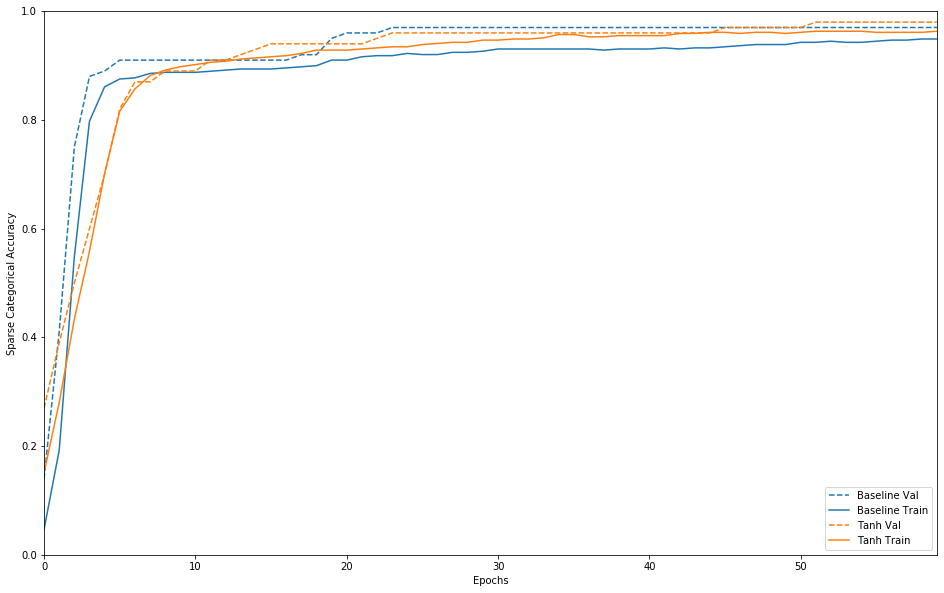

In [43]:
plot_history([('Baseline', b_history), 
            ('tanh', b_history_tanh)])

## 3. Comparison of Results 





##### a. 1 Hidden Layer vs 2 Hidden Layers:

Number of hidden layers is related to model capacity. As number of layers increase, capacity of model will increase and is able to learn more complex functions and thus results in better performance. In this model, we see that the model with 2 hidden layers is performing slightly better than model with 1 hidden layer. The generalization error is less in model with 2 hidden layer. It is better to add more layers to the model than adding more neurons to one existing layer as deeper networks are a more efficient way of utilizing model capacity.Generally speaking, wide networks are good at memorization, but not so good at generalization where as deeper networks are good at generalization and more complex functions can be learned.

##### b.  Number of neurons in hidden layers between (a)2/3 the size of the input layer, plus the size of the output layer, and (b) twice the size of the input layer:


Too few neurons in hidden layers may result in underfitting while having too many neurons may result in overfitting. In this model, number of neurons in hidden layers with twice the size of the input layer is giving better results and accuracy than number of neurons with 2/3 the size of the input layer. Because while increasing the number of neurons we are increasing the capacity of the model which result in  better performance. However, increasing it furthur might result in overfitting of the model. 

#####  c. Regularization:

Regularization is a technique used in neural networks to reduce the generalization gap. It overcomes the issue of overfitting. When the capacity of a model is increased to reduce the training error, there is a possibility of model memorizing the data points which basically results in model performing very well on training data but gives poor performance on new data or validation data. This issue can be resolved using regularization. In this model, L1 regularization  is used  which performs the feature selection and overcomes the issue of overfitting and generaization error.

##### d. Activation function - ReLU and your choice:

'baseline_model' is built using ReLU and 'baseline_model_tanh' is built using tanh activation function. 

ReLu is slightly performing better than Tanh in terms of accuracy and generalization. 'baseline_model' uses ReLU in input and hidden layers and softmax function for output layer. ReLu is less computationally expensive than tanh because it involves simpler mathematical operations and softmax function is used in the output layer for multiclass classification.
'baseline_model_tanh' uses tanh in input and hidden layers and softmax as output function.tanh is better at handling negative values. But, it is computationally more expensive than ReLU.